 <img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Homework worksheet, Tutorial on neuronal encoding and behavior</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 28th, 2025</h3> 
<h3 align="center">Day 4</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

# Question: Does behavioral state change neural encoding of task-relevant stimuli?


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
    
<h3> This question is best answered in a group! </h3>

Before you get too far, sit down with your group and make a plan for how you might answer this. 

<b>Don't jump right in an start writing code! </b>

Here are some things to think about:

+ What do you think the best way to define state is for this question?
+ Given todays theme, you have probably already guessed that we think neural decoding is a good way to tackle this problem. What, specifically, do you want to decode?
+ What do you think the answer to the question is? (i.e. Do you have a hypothesis and null hypothesis to test?)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Have a game plan? Great. 

The idea behind today's homework is for you to work with your group to answer this question. Think of it as a sort of mini project. We will give you some code to get started, but really the goal here is to give you a chance to try your hand at data analysis. Have fun!

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 0: Setup

You are going to need some python packages. Here are the ones from earlier today!
</div>

In [1]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import pynwb

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

pd.set_option('display.max_columns', None)

%matplotlib inline

from tqdm import tqdm  # Displays a smart progress bar during loops

# Sklearn
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

# HMM libraries 
import jax.numpy as jnp
import jax.random as jr

from dynamax.hidden_markov_model import GaussianHMM

# HMM-related imports from JAX, Dynamax, and TensorFlow Probability
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# Additional HMM variants and plotting utilities from Dynamax
from dynamax.hidden_markov_model import (
    DiagonalGaussianHMM,
    SphericalGaussianHMM,
    SharedCovarianceGaussianHMM
)

from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

You will also need to set the path to the data. Again, nothing fancy here - this is straight out of the workshop.
</div>


In [2]:
import platform
from pathlib import Path
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = Path("/Volumes/Brain2025/")
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = Path("E:/")
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = Path("/data/")
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = Path("/media/$USERNAME/Brain2025/")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 1: Data wrangling.

To answer this question, you are going to need some data. 

In day 1 you saw how to use the <b>AllenSDK</b> to access a cache that has information about all of the sessions of Visual Behavior Neuropixels data. The bad news, however, is that the <b>AllenSDK</b> hasn't always kept up with the times Python-wise. Specifically, newer versions of Python required by newer packages don't play nicely with the <b>AllenSDK</b>. The really bad news this includes <b>Dynamax</b> and <b>JAX</b>. 

Since we want to fit HMMs (and generally use more modern code), we need a different way to access our data.

Fortunately, there is a "project_metadata" folder in the data asset attached to CodeOean that contains CSV versions of the what we were previously getting with the <b>AllenSDK</b>.

<i> Note: If you discover that you want <b>AllenSDK</b> for your project you can still run it in a separate capsule or virtual environment. This will allow you to keep it from impacting your more modern code! Ask a TA if you need help making this work.</i>

</div>

In [3]:
ephys_session_table = pd.read_csv('/data/visual-behavior-neuropixels/project_metadata/ecephys_sessions.csv')
ephys_session_table.head()

,ecephys_session_id,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
0,1043752325,1043788445,2020-08-17 15:21:49.664000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,506940,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,266,2207.0,6.0,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,14,1,Familiar,0,869,['Right Cortex'],NaN
1,1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179.0,5.0,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
2,1044389060,1044412710,2020-08-19 15:24:05.052000+00:00,NP.0,EPHYS_1_images_G_5uL_reward,510589,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,242,1645.0,6.0,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,55,1,Familiar,0,871,['Thalamus'],[8899]
3,1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103.0,5.0,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
4,1044597824,1044626338,2020-08-20 15:13:49.880000+00:00,NP.0,EPHYS_1_images_H_5uL_reward,510589,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,243,1948.0,6.0,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,873,['Thalamus'],NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

##  Use this table to choose a session to start with!

Different session have different areas recorded, levels of familiarity, number of probes, mouse genotypes/optotagging, etc. 

Choose one like a good fit for your groups interest. There is no rule that everyone in your group needs to choose the same session - it could be interesting to compare!

The "starter" code before is written with a particular session as an example. If this session suite your needs you are welcome to start there, but at least chat that it is what your really want.


In [4]:
# EXAMPLE: Find sessions with VISp recordings.
VISp_sessions = []
for ii,row in ephys_session_table.iterrows():
    if ('VISp' in row.structure_acronyms) and (row.experience_level == 'Novel'):
        VISp_sessions.append(row.ecephys_session_id)
len(VISp_sessions)

75

In [5]:
# Write your code to choose your own session here


In [11]:
# Load a session!
# For convenience, here are two example sessions with task-engaged and disengaged states: 
# example_session_ids = [1139846596, 1152811536]
example_session =1152811536 # Please! Pick different session!
this_session = str(example_session)
this_filename = f'ecephys_session_{this_session}.nwb'
nwb_path = data_root/'visual-behavior-neuropixels'/'behavior_ecephys_sessions'/this_session/this_filename
print(nwb_path)


/data/visual-behavior-neuropixels/behavior_ecephys_sessions/1152811536/ecephys_session_1152811536.nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets start by reading the NWB

In [12]:
session = pynwb.NWBHDF5IO(nwb_path).read()
session

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Data type,float64
Shape,"(582647, 2)"
Array size,8.89 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(582647,)"
Array size,4.45 MiB
Chunk shape,None


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Next lets grab stimulus information.

You will likely need to change the key from <i>session.intervals</i> you use to to match the session you chose!

In [13]:
# Grab behavior data
trials = session.trials.to_dataframe()
# You may need to edit this key depending on the session you chose!
stimuli = session.intervals['Natural_Images_Lum_Matched_set_ophys_H_2019_presentations'].to_dataframe() 
active_stimuli = stimuli[stimuli.active==True]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, lets pull out our units and do some basic QC.

In [14]:
# Grab electrophysiology data

# Units info
units_table = session.units.to_dataframe()
# electrode info
electrodes_table = session.electrodes.to_dataframe()
# merge unit and electrode info
units_electrode_table = units_table.join(electrodes_table,on = 'peak_channel_id')
# do quick unit QC
good_units = units_electrode_table[
    (units_electrode_table.isi_violations<.5) &
    (units_electrode_table.amplitude_cutoff<.1) &
    (units_electrode_table.presence_ratio>.95)
    ]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 2: Behavioral Modeling

Fit a HMM to your behavior data! Either choose a pre-defined number of states or (even better) go ahead and figure out the "best" number of states to use.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets start by formatting the data the way we had it in the session.

In [15]:
# Get timestamps corresponding to go trials
go_trials = trials[trials.go]
trial_start = go_trials.start_time
trial_stop = go_trials.stop_time

behavior_data = {}

# Count licks
lick_count = go_trials.apply(lambda row : len(row['lick_times']), axis = 1)
behavior_data['lick_count'] = lick_count

# Get running speed and corresponding timestamps
running_data = session.processing['running']
running_timestamps = running_data['speed'].timestamps[:]
running_speed = running_data['speed'].data[:]
running_speed = pd.Series(running_speed).interpolate(limit_direction='both').to_numpy() 
behavior_data['running_speed']  = [np.nanmean(running_speed[np.logical_and(s1 <= running_timestamps, running_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]


# Get pupil area and corresponding timestamps
pupil_data = session.acquisition['EyeTracking']['pupil_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.area[:]
pupil_area = pd.Series(pupil_area).interpolate(limit_direction='both').to_numpy() 
behavior_data['pupil_area'] = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_timestamps, pupil_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

behavior_df = pd.DataFrame(behavior_data)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Remember this handy plotting function? It might be useful here.

In [16]:
def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None, title = "Simulated data from an HMM"):
    """ 
    Make a plot showing HMM state values relative to underlying variables
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True, figsize = (15, 5))
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title(title)
    plt.tight_layout()

    return fig, axs

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Now you are ready to fit a HMM! We will get you started with some simple jpn code. </div>

In [17]:
observations = jnp.array(behavior_df.values)
num_trials, num_dimensions = observations.shape

In [18]:
# First scale the dimensions of the data to be normalized
scaler = StandardScaler()    
observations = scaler.fit_transform(observations)

In [19]:
key = jr.PRNGKey(0)
number_of_states = 4
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=1)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)
most_likely_states = final_hmm.most_likely_states(params, observations)


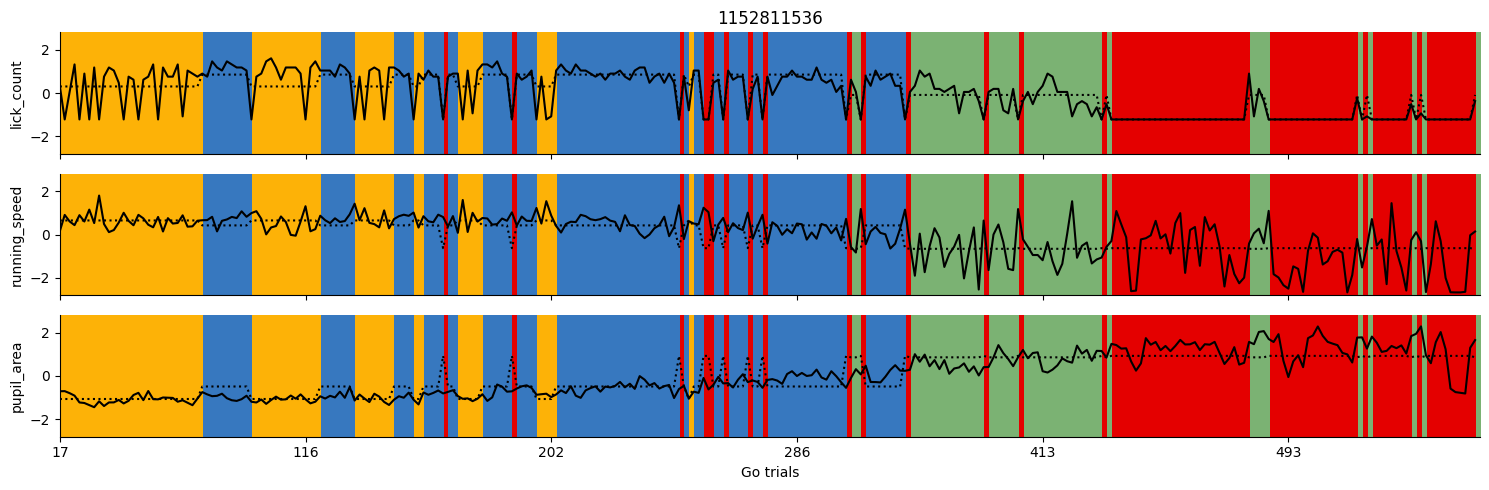

In [20]:
# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)
fig, axs = plot_gaussian_hmm_data(final_hmm, params, observations, most_likely_states, title = f'{this_session}')
# Formatting 
xticks = axs[0].get_xticks().astype(int)[:-1]
for n, ax in enumerate(axs):
    ax.set_xticks(xticks)
    ax.set_xticklabels(go_trials.index.values[xticks])
    ax.set_ylabel(f'{behavior_df.keys()[n]}')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axs[-1].set_xlabel('Go trials')
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

##  Now its time to dig into these data a little.
+ How would you interpret these states? Are there any you think might be particularly relevant for neural activity?
+ Was this the correct number of behavioral states to use? Try checking (remember, we saw how to do this in the workshop!). Does having more or fewer states detected change your plans for neural data analysis?


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

<i>Stretch goal:</i> Electrophysiology data is hard to collect. But these mice spent time running this task when there was no ephys recording. Do you think that using these extra sessions will give you a more robust state estimate? Try concatenating data from several sessions with this mouse - does it change the state estimate for the session at hand?

<i>This part might take you a while, so we recommend trying your hand at decoding some electrophysiology first then coming back to this. </i>

In [21]:
# Here is the behavior_session_table!
behavior_session_table = pd.read_csv('/data/visual-behavior-neuropixels/project_metadata/ecephys_sessions.csv')

In [23]:
behavior_session_table.head()

,ecephys_session_id,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,probe_count,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
0,1043752325,1043788445,2020-08-17 15:21:49.664000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,506940,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,266,2207.0,6.0,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,14,1,Familiar,0,869,['Right Cortex'],NaN
1,1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179.0,5.0,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
2,1044389060,1044412710,2020-08-19 15:24:05.052000+00:00,NP.0,EPHYS_1_images_G_5uL_reward,510589,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,242,1645.0,6.0,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,55,1,Familiar,0,871,['Thalamus'],[8899]
3,1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103.0,5.0,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
4,1044597824,1044626338,2020-08-20 15:13:49.880000+00:00,NP.0,EPHYS_1_images_H_5uL_reward,510589,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,243,1948.0,6.0,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,873,['Thalamus'],NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
### One quick aside before we get to the electrophysiology:
    
We just fit our behavioral model to go trials. But we might wat to decode stimuli fit between these go trials, even though we won't have a good readout of, say, licking for every stimulus presentation. Below is some code to extrapolate the nearest state to these interleaved stimuli. Is this a good idea?

In [24]:
from scipy.interpolate import interp1d
fx = interp1d(go_trials.start_time,most_likely_states,kind="nearest",fill_value="extrapolate")
active_stimuli['state'] = fx(active_stimuli.start_time)

/tmp/ipykernel_305/2038447313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_stimuli['state'] = fx(active_stimuli.start_time)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 3: Decoding electrophysiology. 

Great! You have behavioral states!

Now its time to do some neural decoding.


</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This function is super handy for getting started with binning:


In [25]:
def get_binned_triggered_spike_counts_fast(spike_times, stim_times, bins):
    """
    Fast peri-stimulus time histogram using searchsorted.

    Parameters
    ----------
    spike_times : 1D array_like, sorted
        Times of all spikes (e.g. in seconds).
    stim_times : 1D array_like
        Times of stimulus onsets.
    bins : 1D array_like
        Bin edges *relative* to stimulus (e.g. np.linspace(-0.1, 0.5, 61)).

    Returns
    -------
    counts : 2D ndarray, shape (n_trials, len(bins)-1)
        counts[i, j] is the number of spikes in bin j of trial i.
    """
    # ensure numpy arrays
    spike_times = np.asarray(spike_times)
    stim_times = np.asarray(stim_times)
    bins = np.asarray(bins)

    # If your spike_times isn't already sorted, uncomment:
    # spike_times = np.sort(spike_times)

    n_trials = stim_times.size
    n_bins = bins.size - 1
    counts = np.zeros((n_trials, n_bins), dtype=int)

    for i, stim in enumerate(stim_times):
        # compute the absolute edges for this trial
        edges = stim + bins
        # find the insertion indices for each edge
        idx = np.searchsorted(spike_times, edges, side='left')
        # differences between successive indices = counts per bin
        counts[i, :] = np.diff(idx)

    return counts

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

Choose a structure to look at! The available structures might change depending on the session you have chosen. Hint: there is code in the workshop to check the structures that are available.

In [26]:
# This says "VISp" right now, but feel free to change it want to look at something else!
this_structure_units_table = good_units[good_units.location == 'VISp']

In [29]:

n_neurons = len(this_structure_units_table.spike_times.values)
stim_times = active_stimuli.start_time


bins = np.arange(-0.2,.8,.1)  # Can change window, including baseline time before stimulus
storage = np.empty((n_neurons,len(stim_times),len(bins)-1))

for nn in range(n_neurons):
    spike_times = this_structure_units_table.spike_times.values[nn]

    spike_count = []
    trial_index = []

    storage[nn,:,:]  = get_binned_triggered_spike_counts_fast(spike_times,stim_times,bins)

trial_index = np.arange(len(spike_count))
trial_id_types,trial_id = np.unique(active_stimuli.image_name.values,return_inverse=  True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

Now that you have a storage matrix, you can use it to do some decoding.
Your group discussion should have given you a good idea of what to do next, but here are some pointers in case you get stuck:
+ What are you going to decode? Ideas from the workshop include stimulus identity and change images, but there are other options.
+ Try fitting a model to one or more states. Is your model any good?
+ How does a model fit on one or more states perform on other states? How does this compare to within-state performance?


In [30]:
storage.shape

(72, 4800, 9)

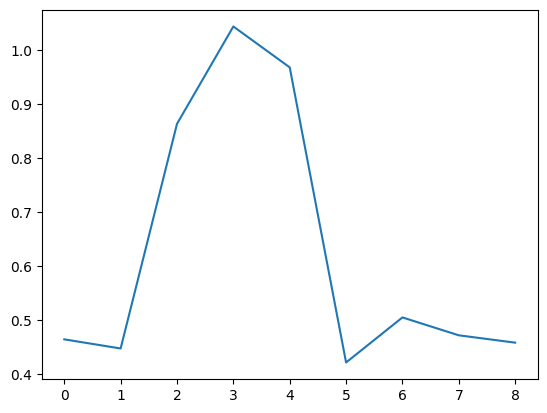

In [32]:
plt.plot(np.mean(storage,axis=(0,1)))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 4: The sky is the limit

Congrats, you made it to the end of the homework worksheet. Does this mean you are done with these data and the next step is to pack your bags and hop a sea plane home? We really hope not; there is still so much more to learn here!

Here are some decoding- and state-inspired ideas for things to try next with these data. If you have time, it could be great to get started! Who knows, thinking like this could even help you towards a project idea.

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

#### Idea (1)

Try playing around with different brain areas by selection a different cell location. How does this change your decoding results. 

+ Is it what you expected? 

+ Do different areas behave differently in different states?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

#### Idea (2)
    
Remember how we made such a big deal about the StandardScalar? Lets revisit that for a moment. 

Applying the StandardScalar to your model normalizes the magnitude of all of your neurons. For linear models, this has a key advantage: it makes the scale of all of the coefficients in your model comparable. In other words, you can get a sense of which neuron is of more importance to your model by looking which neurons have larger coefficients once your model is fit.

Using these coefficients can be a handy way to explore your data. One you have your coefficients, try looking "most important" neurons. Plot a raster! How does this compare to the "least important" neurons.

In [ ]:
# svc = LinearSVC()
# svc.fit(X,y)
# svc.coef_ #Coefficients

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

#### Idea (3) 
Flip the script! Can you decode which state your mouse is in from the neural activity?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

#### Idea (4) 

We have more information about are neurons than just "are they good?"

Canonically, electrophysiology literature has separated "fast spiking" and "regular spiking" units based on the width of their spike waveform. Though the distinction is far from perfect, "fast spiking" units are thought more likely to be PV-positive interneurons, while other cells fall into the "regular" camp. 

There are other, more sophisticated ways to distinguish cell types. For example, many of these sessions have optotaging information. https://allenswdb.github.io/background/Optotagging.html

Try decoding again, but this time separating by cell type. Plot a histogram of unit waveform durations. Where might you draw the line between fast and regular spiking neurons? Try decoding with each of these cell types and comparing the results. Hint: you might want subsample these populations to make them the same size.

Once you have this working, you might even take a look at the specific populations of optotagged cells.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

#### Idea (5) 

The HMMs we have been using for this session are great, but they are complicated models. If possible, it is often best to use the simplest model possible. Today, you learned about two other unsupervised clustering methods: K-Means and Gaussian Mixture models. Try fitting each of these to your behavior session. How do the results differ from the fit of an HMM?

<i> Hint: <b>sklearn</b> has prefabricated structures for fitting both KMeans and Gaussian Mixture models. These are the easiest way to get started (though K-Means is fun to build from scratch if you are feeling like a challenge!).</i>

In [1]:
# Hint:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
